In [10]:
from __future__ import division
from __future__ import print_function
from sklearn import metrics
import random
import time
import sys
import os

import torch
import torch.nn as nn

import numpy as np

from utils.utils import *
from models.gcn import GCN
from models.mlp import MLP

from config import CONFIG
cfg = CONFIG()


dataset = 'Goggles'

cfg.dataset = dataset

# Set random seed
seed = random.randint(1, 200)
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)


# Settings
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(
    cfg.dataset)

features = sp.identity(features.shape[0])  # featureless


# Some preprocessing
features = preprocess_features(features)
if cfg.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif cfg.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, cfg.max_degree)
    num_supports = 1 + cfg.max_degree
    model_func = GCN
elif cfg.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(cfg.model))


# Define placeholders
t_features = torch.from_numpy(features)
t_y_train = torch.from_numpy(y_train)
t_y_val = torch.from_numpy(y_val)
t_y_test = torch.from_numpy(y_test)
t_train_mask = torch.from_numpy(train_mask.astype(np.float32))
tm_train_mask = torch.transpose(torch.unsqueeze(t_train_mask, 0), 1, 0).repeat(1, y_train.shape[1])

t_support = []
for i in range(len(support)):
    t_support.append(torch.Tensor(support[i]))

# if torch.cuda.is_available():
#     model_func = model_func.cuda()
#     t_features = t_features.cuda()
#     t_y_train = t_y_train.cuda()
#     t_y_val = t_y_val.cuda()
#     t_y_test = t_y_test.cuda()
#     t_train_mask = t_train_mask.cuda()
#     tm_train_mask = tm_train_mask.cuda()
#     for i in range(len(support)):
#         t_support = [t.cuda() for t in t_support if True]
        
model = model_func(input_dim=features.shape[0], support=t_support, num_classes=y_train.shape[1])


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)


# Define model evaluation function
def evaluate(features, labels, mask):
    t_test = time.time()
    # feed_dict_val = construct_feed_dict(
    #     features, support, labels, mask, placeholders)
    # outs_val = sess.run([model.loss, model.accuracy, model.pred, model.labels], feed_dict=feed_dict_val)
    model.eval()
    with torch.no_grad():
        logits = model(features)
        t_mask = torch.from_numpy(np.array(mask*1., dtype=np.float32))
        tm_mask = torch.transpose(torch.unsqueeze(t_mask, 0), 1, 0).repeat(1, labels.shape[1])
        loss = criterion(logits * tm_mask, torch.max(labels, 1)[1])
        pred = torch.max(logits, 1)[1]
        acc = ((pred == torch.max(labels, 1)[1]).float() * t_mask).sum().item() / t_mask.sum().item()
        
    return loss.numpy(), acc, pred.numpy(), labels.numpy(), (time.time() - t_test)



val_losses = []



In [11]:
print(t_features.shape) 
print( t_y_train.shape)
print(t_y_val.shape)
print(t_y_test.shape)

torch.Size([9389, 9389])
torch.Size([9389, 129])
torch.Size([9389, 129])
torch.Size([9389, 129])


In [12]:
# Train model
for epoch in range(cfg.epochs):

    t = time.time()
    
    # Forward pass
    logits = model(t_features)
    loss = criterion(logits * tm_train_mask, torch.max(t_y_train, 1)[1])    
    acc = ((torch.max(logits, 1)[1] == torch.max(t_y_train, 1)[1]).float() * t_train_mask).sum().item() / t_train_mask.sum().item()
        
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    val_loss, val_acc, pred, labels, duration = evaluate(t_features, t_y_val, val_mask)
    val_losses.append(val_loss)

    print_log("Epoch: {:.0f}, train_loss= {:.5f}, train_acc= {:.5f}, val_loss= {:.5f}, val_acc= {:.5f}, time= {:.5f}"\
                .format(epoch + 1, loss, acc, val_loss, val_acc, time.time() - t))

    if epoch > cfg.early_stopping and val_losses[-1] > np.mean(val_losses[-(cfg.early_stopping+1):-1]):
        print_log("Early stopping...")
        break


print_log("Optimization Finished!")




[2021/3/31 12:59:38] Epoch: 1, train_loss= 4.88838, train_acc= 0.01393, val_loss= 4.85747, val_acc= 0.02899, time= 1.19679
[2021/3/31 12:59:40] Epoch: 2, train_loss= 4.82621, train_acc= 0.02999, val_loss= 4.85301, val_acc= 0.14010, time= 1.24467
[2021/3/31 12:59:41] Epoch: 3, train_loss= 4.76991, train_acc= 0.18050, val_loss= 4.84888, val_acc= 0.21739, time= 1.20877
[2021/3/31 12:59:42] Epoch: 4, train_loss= 4.71724, train_acc= 0.30530, val_loss= 4.84497, val_acc= 0.25604, time= 1.39527
[2021/3/31 12:59:44] Epoch: 5, train_loss= 4.66743, train_acc= 0.35137, val_loss= 4.84127, val_acc= 0.28502, time= 1.46209
[2021/3/31 12:59:45] Epoch: 6, train_loss= 4.62016, train_acc= 0.37547, val_loss= 4.83776, val_acc= 0.28019, time= 1.54885
[2021/3/31 12:59:47] Epoch: 7, train_loss= 4.57534, train_acc= 0.39368, val_loss= 4.83442, val_acc= 0.29952, time= 1.48104
[2021/3/31 12:59:48] Epoch: 8, train_loss= 4.53291, train_acc= 0.41885, val_loss= 4.83118, val_acc= 0.30435, time= 1.60289
[2021/3/31 12:59

In [14]:
# Testing
test_loss, test_acc, pred, labels, test_duration = evaluate(t_features, t_y_test, test_mask)
print_log("Test set results: \n\t loss= {:.5f}, accuracy= {:.5f}, time= {:.5f}".format(test_loss, test_acc, test_duration))

test_pred = []
test_labels = []
for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(np.argmax(labels[i]))


print_log("Test Precision, Recall and F1-Score...")
print_log(metrics.classification_report(test_labels, test_pred, digits=4))
print_log("Macro average Test Precision, Recall and F1-Score...")
print_log(metrics.precision_recall_fscore_support(test_labels, test_pred, average='macro'))
print_log("Micro average Test Precision, Recall and F1-Score...")
print_log(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

# doc and word embeddings
tmp = model.layer1.embedding.numpy()
word_embeddings = tmp[train_size: adj.shape[0] - test_size]
train_doc_embeddings = tmp[:train_size]  # include val docs
test_doc_embeddings = tmp[adj.shape[0] - test_size:]

print_log('Embeddings:')
print_log('\rWord_embeddings:'+str(len(word_embeddings)))
print_log('\rTrain_doc_embeddings:'+str(len(train_doc_embeddings))) 
print_log('\rTest_doc_embeddings:'+str(len(test_doc_embeddings))) 
print_log('\rWord_embeddings:') 
print(word_embeddings)

with open('./data/corpus/' + dataset + '_vocab.txt', 'r') as f:
    words = f.readlines()

vocab_size = len(words)
word_vectors = []
for i in range(vocab_size):
    word = words[i].strip()
    word_vector = word_embeddings[i]
    word_vector_str = ' '.join([str(x) for x in word_vector])
    word_vectors.append(word + ' ' + word_vector_str)

word_embeddings_str = '\n'.join(word_vectors)
with open('./data/' + dataset + '_word_vectors.txt', 'w') as f:
    f.write(word_embeddings_str)



doc_vectors = []
doc_id = 0
for i in range(train_size):
    doc_vector = train_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

for i in range(test_size):
    doc_vector = test_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

doc_embeddings_str = '\n'.join(doc_vectors)
with open('./data/' + dataset + '_doc_vectors.txt', 'w') as f:
    f.write(doc_embeddings_str)




[2021/3/31 13:02:15] Test set results: 
[2021/3/31 13:02:15] 	 loss= 4.68991, accuracy= 0.61614, time= 0.37200
[2021/3/31 13:02:15] Test Precision, Recall and F1-Score...
[2021/3/31 13:02:15]               precision    recall  f1-score   support
[2021/3/31 13:02:15] 
[2021/3/31 13:02:15]            0     0.5000    0.3333    0.4000         3
[2021/3/31 13:02:15]            1     0.0000    0.0000    0.0000         3
[2021/3/31 13:02:15]            2     0.8750    0.7778    0.8235         9
[2021/3/31 13:02:15]            3     0.1667    0.4000    0.2353         5
[2021/3/31 13:02:15]            4     1.0000    0.5000    0.6667         2
[2021/3/31 13:02:15]            5     0.5000    0.2000    0.2857         5
[2021/3/31 13:02:15]            6     0.8000    0.5714    0.6667         7
[2021/3/31 13:02:15]            7     0.0000    0.0000    0.0000         4
[2021/3/31 13:02:15]            8     0.0000    0.0000    0.0000         2
[2021/3/31 13:02:15]            9     0.5000    0.3333   

C:\Users\adity\anaconda3\envs\nlu\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


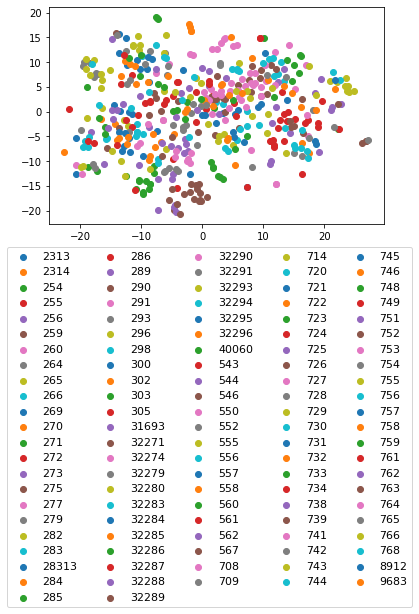

In [5]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
import os


data_set = 'Goggles' # 20ng R8 R52 ohsumed mr
data_path = './data'


f = open(os.path.join(data_path, data_set + '.train.index'), 'r')
lines = f.readlines()
f.close()
train_size = len(lines)


f = open(os.path.join(data_path, data_set + '_shuffle.txt'), 'r')
lines = f.readlines()
f.close()

target_names = set()
labels = []
for line in lines:
    line = line.strip()
    temp = line.split('\t')
    labels.append(temp[2])
    target_names.add(temp[2])

target_names = list(target_names)

f = open(os.path.join(data_path, data_set + '_doc_vectors.txt'), 'r')
lines = f.readlines()
f.close()

docs = []
for line in lines:
    temp = line.strip().split()
    values_str_list = temp[1:]
    values = [float(x) for x in values_str_list]
    docs.append(values)

fea = docs[train_size:]  # int(train_size * 0.9)
label = labels[train_size:]  # int(train_size * 0.9)
label = np.array(label)

fea = TSNE(n_components=2).fit_transform(fea)
pdf = PdfPages(data_set + '_gcn_doc_test.pdf')
cls = np.unique(label)

# cls=range(10)
fea_num = [fea[label == i] for i in cls]
for i, f in enumerate(fea_num):
    if cls[i] in range(10):
        plt.scatter(f[:, 0], f[:, 1], label=cls[i], marker='+')
    else:
        plt.scatter(f[:, 0], f[:, 1], label=cls[i])
plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.48, -0.08), fontsize=11)
# plt.ylim([-20,35])
# plt.title(md_file)
plt.tight_layout()
pdf.savefig()
plt.show()
pdf.close()
